In [1]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-w8aopoyt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-w8aopoyt
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184222 sha256=b6123c9a3282761ba7529e00e26e3775653c06d428b3c31b73740cdb72571f1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0d7cawwt/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/MS Sem 3/DATA 255 Deep Learning"

In [4]:
import os
import numpy as np
#import matplotlib.pyplot as pyplot
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds


import glob
import imageio
import matplotlib.pyplot as plt

import PIL
from tensorflow.keras import layers
import time

 
from IPython import display

In [5]:
# loading the fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the images into memory
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


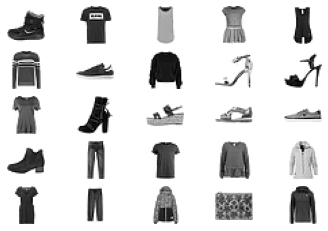

In [6]:
#plot of 25 images from the Fashion MNIST training dataset, arranged in a 5×5 square.
 

# plot images from the training dataset
for i in range(25):
  # define subplot
  plt.subplot(5, 5, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(trainX[i], cmap='gray_r')
plt.show()


In [8]:
#setting the training space
(trn_imag, trn_labl), (_, _) = fashion_mnist.load_data()

In [6]:
trn_imag.shape

(60000, 28, 28)

In [7]:
trn_labl.shape

(60000,)

In [8]:
_.shape

(10000,)

In [9]:
trn_imag = trn_imag.reshape(trn_imag.shape[0], 28, 28, 1).astype('float32')
trn_imag = (trn_imag - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [10]:
#setting the buffer and batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data
trn_data = tf.data.Dataset.from_tensor_slices(trn_imag).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator

In [12]:
# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose 
# convolution in combination with batch normalization. 


def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
   # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

Using as yet untrained generator to generate the image

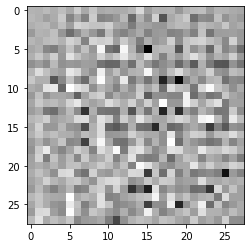

In [13]:
# sample image generated by the the generator
genG = genG_model()
 
noise = tf.random.normal([1, 100]) #latent space
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator


In [14]:
# Input to discriminator = 28*28*1   grayscale image
# Output  binary prediction (image is real (class=1) or fake (class=0))
# no pooling layers  
# single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 
# Downsampling from 28×28 to 14×14, then to 7×7, before the model makes an output prediction
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD

Using as yet untrained discriminator to classify the image

In [15]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)

tf.Tensor([[0.50017864]], shape=(1, 1), dtype=float32)



### Define the loss and optimizers

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriM_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [18]:
def genG_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# Saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                 discriM_optimizer=discriM_optimizer,
                                 genG=genG,
                                 discriM=discriM)


Define the training loop

In [21]:
#defining the number of epochs to train for
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
 
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
def trn_img(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

In [23]:
def train(dataset, epochs):
  j = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      discriM.save('CheckPoint/Dis%d'%j)
      genG.save('CheckPoint/Gen%d'%j)
      j = j+1
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

Generate and save images

In [24]:
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Training the model

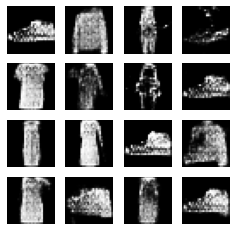

In [25]:
train(trn_data, EPOCHS)

### Loading the model using the saved weights

In [25]:
from tensorflow.keras.models import load_model

sgmodel = load_model('CheckPoint/Gen2')
sdmodel = load_model('CheckPoint/Dis2')
sgmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [27]:
def trn_img_loaded(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = sgmodel(noise, training=True)

      real_output = sdmodel(images, training=True)
      fake_output = sdmodel(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, sgmodel.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, sdmodel.trainable_variables)
    
    genG_optimizer.apply_gradients(zip(grad_genG, sgmodel.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, sdmodel.trainable_variables))

In [28]:
def train_load_img(dataset, epochs):
  j = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img_loaded(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(sgmodel, epoch + 1, seed)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(sgmodel, epochs, seed)

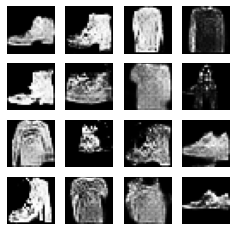

In [30]:
train_load_img(trn_data, 50)

It can be seen that the model gives a better output when retrained using the saved weights.

Save the model without using checkpoints

In [26]:
checkpoint_dir = './training_checkpoints'

In [27]:
genG.save('./training_checkpoints/genG.h5')
discriM.save('./training_checkpoints/discriM.h5')

Load the model without using checkpoints

In [28]:
genG = tf.keras.models.load_model('./training_checkpoints/genG.h5')
discriM = tf.keras.models.load_model('./training_checkpoints/discriM.h5')

### Save and display 3 samples from the GAN model

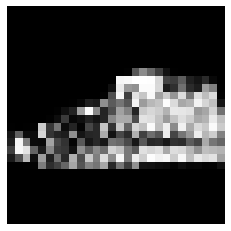

In [29]:
predictions = genG(seed, training=False)
plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.savefig('Sample_Image_1.png')
plt.show()

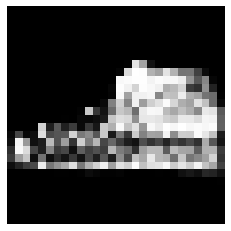

In [30]:
predictions = genG(seed, training=False)
plt.imshow(predictions[10, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.savefig('Sample_Image_1.png')
plt.show()

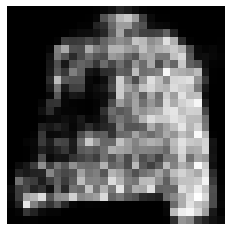

In [32]:
predictions = genG(seed, training=False)
plt.imshow(predictions[11, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.savefig('Sample_Image_1.png')
plt.show()

## **LSGAN**

## Genarator

In [49]:
# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose 
# convolution in combination with batch normalization. 


def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
   # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

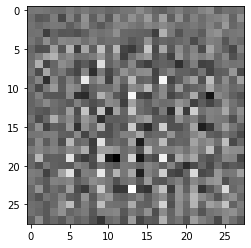

In [50]:
# sample image generated by the the generator
genG = genG_model()
 
noise = tf.random.normal([1, 100]) #latent space
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

In [51]:
# Input to discriminator = 28*28*1   grayscale image
# Output  binary prediction (image is real (class=1) or fake (class=0))
# no pooling layers  
# single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 
# Downsampling from 28×28 to 14×14, then to 7×7, before the model makes an output prediction
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD

In [52]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)


tf.Tensor([[0.50125545]], shape=(1, 1), dtype=float32)


In [53]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse_loss = tf.keras.losses.MeanSquaredError()

In [54]:
def discriM_loss(real_output, fake_output):
    real_loss = mse_loss(tf.ones_like(real_output), real_output)
    fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [55]:
def genG_loss(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

In [56]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

### Training the model

In [57]:
#defining the number of epochs to train for
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
 
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [58]:
def trn_img(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

In [59]:
def train(dataset, epochs):
  j=0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      discriM.save('CheckPoint/Dis%d'%j)
      genG.save('CheckPoint/Gen%d'%j)
      j=j+1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

In [60]:
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

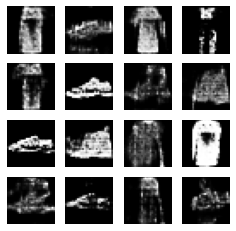

In [61]:
train(trn_data, EPOCHS)

### Loading the model using the saved weights

In [62]:
from tensorflow.keras.models import load_model

sgmodel = load_model('CheckPoint/Gen2')
sdmodel = load_model('CheckPoint/Dis2')
sgmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [63]:
def trn_img_loaded(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = sgmodel(noise, training=True)

      real_output = sdmodel(images, training=True)
      fake_output = sdmodel(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, sgmodel.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, sdmodel.trainable_variables)
    
    genG_optimizer.apply_gradients(zip(grad_genG, sgmodel.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, sdmodel.trainable_variables))

In [64]:
def train_load_img(dataset, epochs):
  j = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img_loaded(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(sgmodel, epoch + 1, seed)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(sgmodel, epochs, seed)

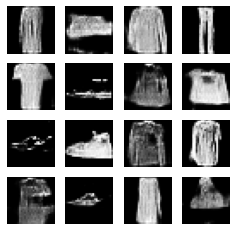

In [65]:
train_load_img(trn_data, 50)

It can be seen that the model gives a better output when retrained using the saved weights.

From the results, It can be seen that LSGAN performed better than regular GAN.